In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from math import sqrt

#Settings
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(threshold=np.nan)
sns.set()
DIMS=(16, 6)

df_hours = pd.read_csv('hour.csv')

### Data exploration

In [2]:
#Check if there is any missing value
df_hours.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [3]:
#rename columns
df_hours.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                         'atemp': 'feeling_temp',
                         'temp': 'actual_temp',
                        'hum':'humidity',
                        'mnth':'month',
                         'hr':'hour',
                         'yr':'year',
                        'cnt':'total_user'},inplace=True)

In [4]:
df_hours.shape

(17379, 17)

In [5]:
df_hours.dtypes

rec_id                 int64
datetime              object
season                 int64
year                   int64
month                  int64
hour                   int64
is_holiday             int64
weekday                int64
is_workingday          int64
weather_condition      int64
actual_temp          float64
feeling_temp         float64
humidity             float64
windspeed            float64
casual                 int64
registered             int64
total_user             int64
dtype: object

In [6]:
df_hours.head(5)

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_user
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.29,0.81,0.00,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.27,0.80,0.00,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.27,0.80,0.00,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.29,0.75,0.00,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.29,0.75,0.00,0,1,1


In [7]:
df_hours.describe()

,rec_id,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_user
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,8690.00,2.50,0.50,6.54,11.55,0.03,3.00,0.68,1.43,0.50,0.48,0.63,0.19,35.68,153.79,189.46
std,5017.03,1.11,0.50,3.44,6.91,0.17,2.01,0.47,0.64,0.19,0.17,0.19,0.12,49.31,151.36,181.39
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.02,0.00,0.00,0.00,0.00,0.00,1.00
25%,4345.50,2.00,0.00,4.00,6.00,0.00,1.00,0.00,1.00,0.34,0.33,0.48,0.10,4.00,34.00,40.00
50%,8690.00,3.00,1.00,7.00,12.00,0.00,3.00,1.00,1.00,0.50,0.48,0.63,0.19,17.00,115.00,142.00
75%,13034.50,3.00,1.00,10.00,18.00,0.00,5.00,1.00,2.00,0.66,0.62,0.78,0.25,48.00,220.00,281.00
max,17379.00,4.00,1.00,12.00,23.00,1.00,6.00,1.00,4.00,1.00,1.00,1.00,0.85,367.00,886.00,977.00


In [8]:
df_hours.shape

(17379, 17)

Check for skewness and kurtosis

In [9]:
df_hours.skew()

rec_id               0.00
season              -0.01
year                -0.01
month               -0.01
hour                -0.01
is_holiday           5.64
weekday             -0.00
is_workingday       -0.79
weather_condition    1.23
actual_temp         -0.01
feeling_temp        -0.09
humidity            -0.11
windspeed            0.57
casual               2.50
registered           1.56
total_user           1.28
dtype: float64

In [10]:
df_hours.kurtosis()

rec_id              -1.20
season              -1.33
year                -2.00
month               -1.20
hour                -1.20
is_holiday          29.80
weekday             -1.26
is_workingday       -1.38
weather_condition    0.35
actual_temp         -0.94
feeling_temp        -0.85
humidity            -0.83
windspeed            0.59
casual               7.57
registered           2.75
total_user           1.42
dtype: float64

Check if outliers exist

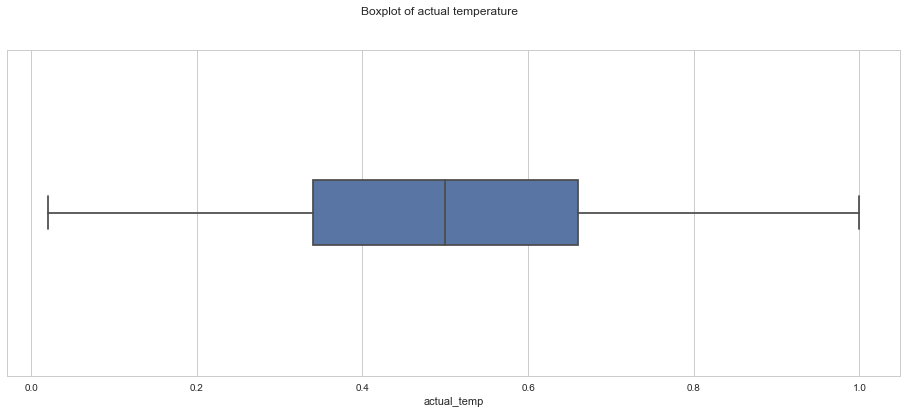

In [11]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=DIMS)
fig.add_subplot(111)
sns.boxplot(df_hours['actual_temp'], orient="h", width=0.2)
fig.suptitle('Boxplot of actual temperature', fontsize=12)
plt.show()

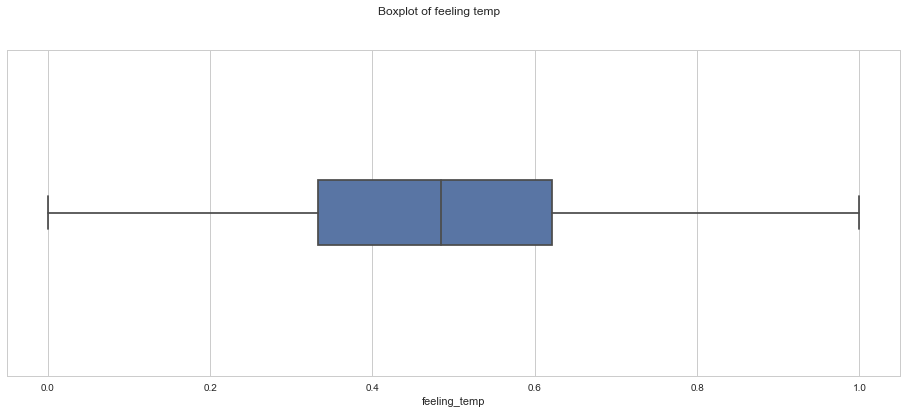

In [12]:
fig = plt.figure(figsize=DIMS)
fig.add_subplot(111)
sns.boxplot(df_hours['feeling_temp'], orient="h", width=0.2)
fig.suptitle('Boxplot of feeling temp', fontsize=12)
plt.show()

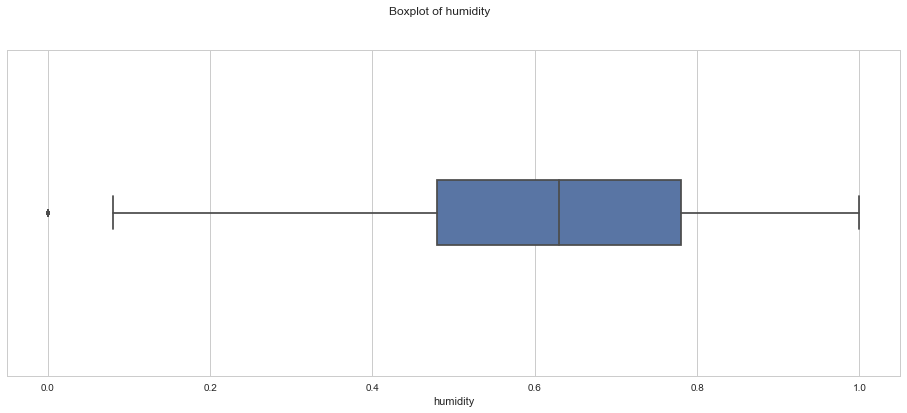

In [13]:
fig = plt.figure(figsize=DIMS)
fig.add_subplot(111)
sns.boxplot(df_hours['humidity'], orient="h", width=0.2)
fig.suptitle('Boxplot of humidity', fontsize=12)
plt.show()

In [14]:
p75_humidity = np.percentile(df_hours['humidity'], 75)
p25_humidity = np.percentile(df_hours['humidity'], 25)
iqr_humidity = p75_humidity - p25_humidity
lower_bound_humidity = p25_humidity - 1.5*iqr_humidity

print("lower bound humidity:{:.2f} ".format(lower_bound_humidity))

df_hours_humidity_lower_outliers = df_hours.copy()
df_hours_humidity_lower_outliers = df_hours_humidity_lower_outliers[df_hours_humidity_lower_outliers['humidity']<lower_bound_humidity]
print(df_hours_humidity_lower_outliers.shape)

df_hours_humidity_lower_outliers['humidity'].unique()

#There are 22 records that are lower outliers in humidity, where humidity = 0.03. 
#These records will be filtered
df_hours_remove_humidity_lower_outliers = df_hours.copy()
df_hours_remove_humidity_lower_outliers = df_hours_remove_humidity_lower_outliers[~(df_hours_remove_humidity_lower_outliers['humidity'] == 0.0)]
df_hours_remove_humidity_lower_outliers.shape


lower bound humidity:0.03 
(22, 17)


(17357, 17)

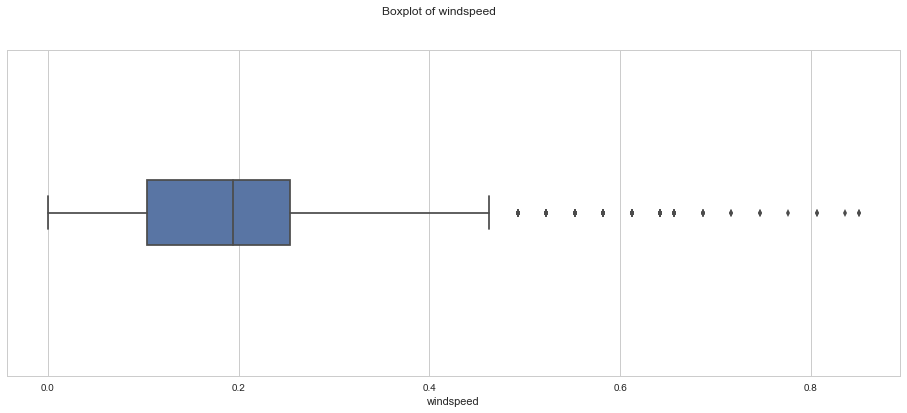

In [15]:
fig = plt.figure(figsize=DIMS)
fig.add_subplot(111)
sns.boxplot(df_hours['windspeed'], orient="h", width=0.2)
fig.suptitle('Boxplot of windspeed', fontsize=12)
plt.show()

#### Remove upper outliers of 'windspeed' from filtered df that eliminated lower outliers of 'humidity'

In [16]:
p75_windspeed = np.percentile(df_hours['windspeed'], 75)
p25_windspeed = np.percentile(df_hours['windspeed'], 25)
iqr_windspeed = p75_windspeed - p25_windspeed
upper_bound_windspeed = p75_windspeed + 1.5*iqr_windspeed
print("upper bound windspeed:{:.2f} ".format(upper_bound_windspeed))

# df_hours_remove_windspeed_upper_outliers = df_hours_remove_humidity_lower_outliers.copy()
# df_hours_remove_windspeed_upper_outliers = df_hours_remove_windspeed_upper_outliers[~(df_hours_remove_windspeed_upper_outliers['windspeed']>upper_bound_windspeed)]

df_hours_windspeed_upper_outliers = df_hours_remove_humidity_lower_outliers.copy()
df_hours_windspeed_upper_outliers = df_hours_windspeed_upper_outliers[df_hours_windspeed_upper_outliers['windspeed']>upper_bound_windspeed]
print(df_hours_windspeed_upper_outliers.shape[0])

#There are 341 records that are upper outliers in windspeed, where windspeed = 0.48. 
#These records will be filtered

df_hours_remove_windspeed_upper_outliers = df_hours_remove_humidity_lower_outliers.copy()
df_hours_remove_windspeed_upper_outliers = df_hours_remove_windspeed_upper_outliers[~(df_hours_remove_windspeed_upper_outliers['windspeed']>upper_bound_windspeed)]

clean_df_hours = df_hours_remove_windspeed_upper_outliers
clean_df_hours.head()

upper bound windspeed:0.48 
341


,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_user
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.29,0.81,0.00,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.27,0.80,0.00,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.27,0.80,0.00,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.29,0.75,0.00,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.29,0.75,0.00,0,1,1


In [17]:
clean_df_hours.describe()

,rec_id,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_user
count,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00,17016.00
mean,8719.64,2.52,0.50,6.57,11.50,0.03,3.00,0.68,1.42,0.50,0.48,0.63,0.18,35.78,154.05,189.83
std,5009.38,1.10,0.50,3.43,6.93,0.17,2.01,0.47,0.64,0.19,0.17,0.19,0.11,49.42,151.68,181.76
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.02,0.00,0.08,0.00,0.00,0.00,1.00
25%,4393.75,2.00,0.00,4.00,6.00,0.00,1.00,0.00,1.00,0.34,0.33,0.48,0.10,4.00,34.00,40.00
50%,8697.50,3.00,1.00,7.00,11.00,0.00,3.00,1.00,1.00,0.50,0.48,0.64,0.16,17.00,116.00,142.00
75%,13075.25,3.00,1.00,10.00,18.00,0.00,5.00,1.00,2.00,0.66,0.62,0.79,0.25,48.25,221.00,282.00
max,17379.00,4.00,1.00,12.00,23.00,1.00,6.00,1.00,4.00,1.00,1.00,1.00,0.46,367.00,886.00,977.00


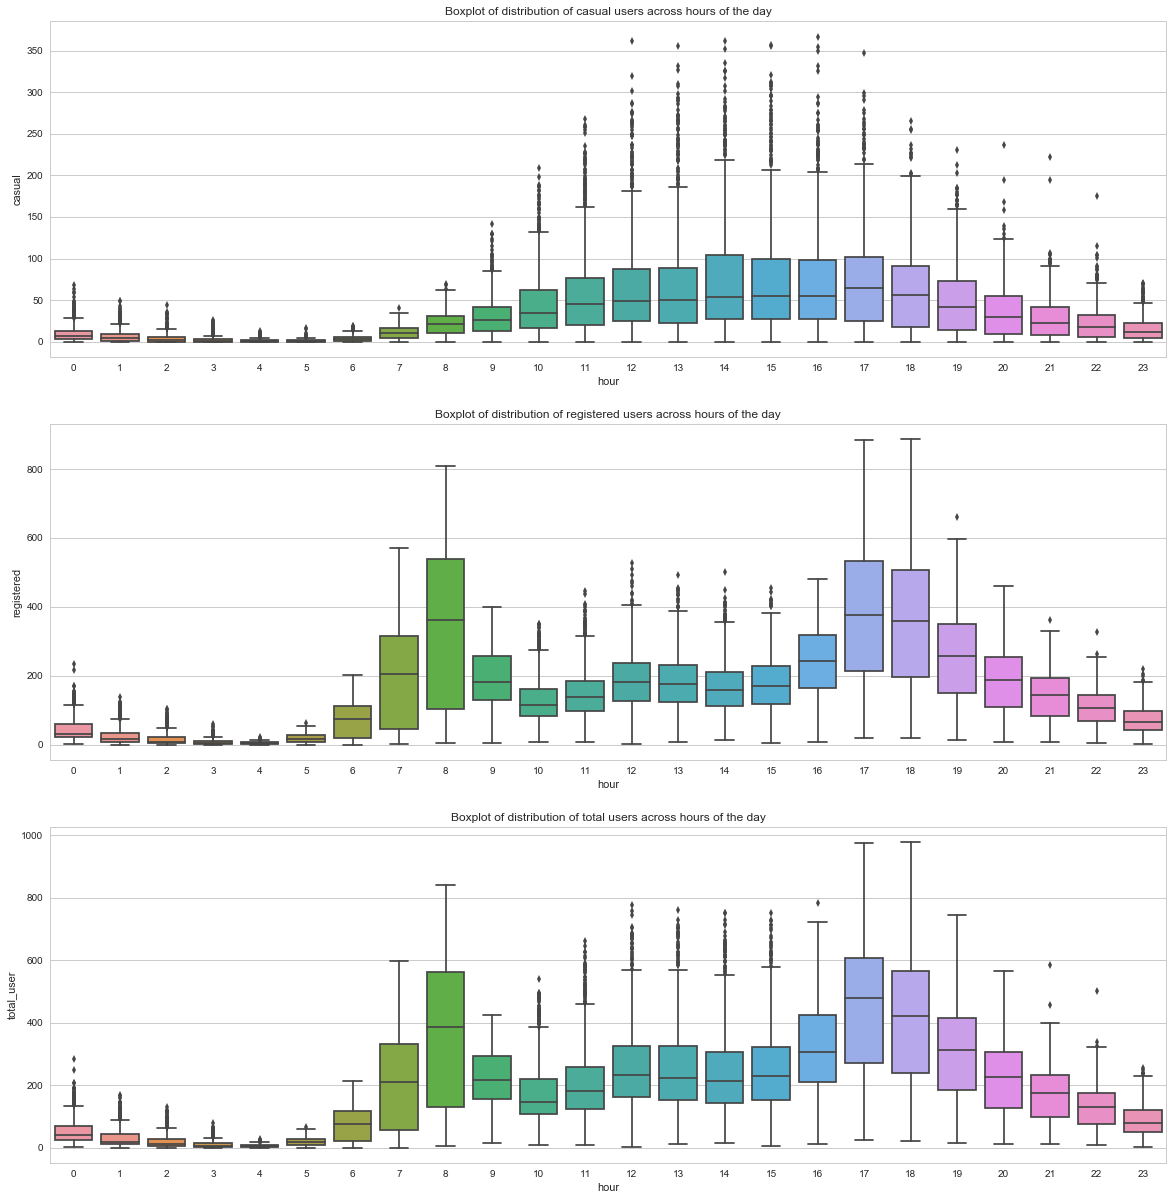

In [18]:
fig = plt.figure(figsize= (20,21))
ax1=fig.add_subplot(311)
ax2=fig.add_subplot(312)
ax3=fig.add_subplot(313)


sns.boxplot(data=clean_df_hours[['hour', 'casual']],x='hour',y='casual', ax=ax1)
ax1.set_title('Boxplot of distribution of casual users across hours of the day', fontsize=12)

sns.boxplot(data=clean_df_hours[['hour', 'registered']],x='hour',y='registered', ax=ax2)
ax2.set_title('Boxplot of distribution of registered users across hours of the day', fontsize=12)

sns.boxplot(data=clean_df_hours[['hour', 'total_user']],x='hour',y='total_user', ax=ax3)
ax3.set_title('Boxplot of distribution of total users across hours of the day', fontsize=12)

plt.show()

From these boxplots, we see that the distribution of registered users count follows a similar pattern as the total users, and the two peaks in registered users distribution correspond to that in total users, which are during morning and evening time, when people go to work. This suggests that most of the registered users are working people.  On the other hand, casual users follow a different pattern with similar demand in the afternoon till late afternoon. Thus, we can conclude that ‘hour’ is significant variable which distinguishes registered user count prediction. 

Thus, bike rentals can be segregated into 3 categories across the day:
1. High : 6:00-9:00 and 17:00-20:00
2. Average : 10:00-16:00
3. Low : 0:00-5:00 and 21:00-23:00

Even though some outliers exist, I'll not remove them, since I assume they are natural outliers.

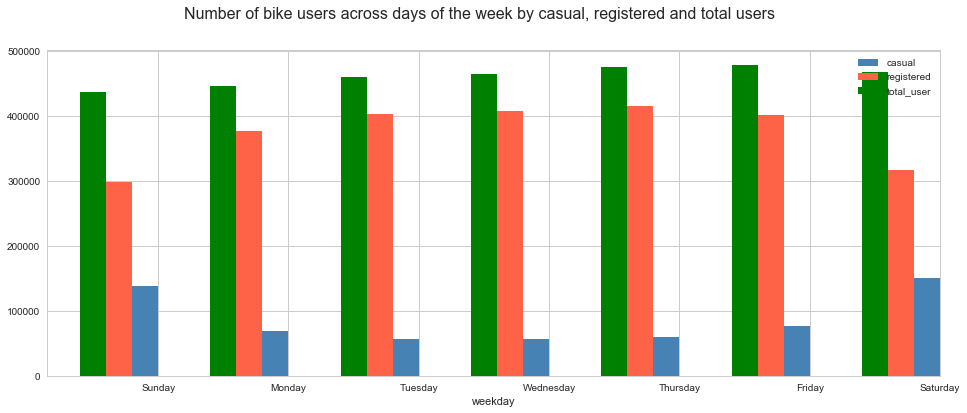

In [19]:
users_weekday_df = clean_df_hours[['weekday', 'casual', 'registered', 'total_user']]
# users_weekday_df.head(10)

users_weekday_df_agg = users_weekday_df.groupby('weekday').sum()
users_weekday_df_agg.head(7)


width=0.20
fig = plt.figure(figsize=DIMS)
ax = fig.add_subplot(111)

users_weekday_df_agg.plot(kind='bar',  y='casual', ax=ax, position=1, width=width, color='steelblue',rot = 0)
users_weekday_df_agg.plot(kind='bar',  y='registered', ax=ax, position=2, width=width, color='tomato',rot = 0)
users_weekday_df_agg.plot(kind='bar',  y='total_user', ax=ax, position=3, width=width, color='green',rot = 0)

fig.suptitle("Number of bike users across days of the week by casual, registered and total users", fontsize=16)
ax.set_xticklabels(('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday')) 
plt.show()

From the barchart, we see that registered users use bikes more on the weekdays as compared to the weekends, while the reverse is observed for casual users. This reinforced my earlier hypothesis that registered bike users are working adults who probably cycle to their workplace. From this graph, we can tell that more casual users cycle on the weekends maybe because they cycle for leisure.

In [20]:
years_df_hours = clean_df_hours.copy()
years_df_hours = years_df_hours[['total_user','casual', 'registered', 'year']]
years_df_hours_agg = years_df_hours.groupby('year').sum().reset_index()
years_df_hours_agg['percentage_casual'] = years_df_hours_agg['casual']/years_df_hours_agg['total_user']*100
years_df_hours_agg['percentage_registered'] = years_df_hours_agg['registered']/years_df_hours_agg['total_user']*100
years_df_hours_agg

,year,total_user,casual,registered,percentage_casual,percentage_registered
0,0,1220325,242629,977696,19.88,80.12
1,1,2009876,366276,1643600,18.22,81.78


While the proportion of registered and casual users across 2011 and 2012 are similar, based on year on year growth, there is significantly more uptake in registered users in 2012 than in 2011. 

In [21]:
month_df_hours = clean_df_hours.copy()
month_df_hours = month_df_hours[['total_user','casual', 'registered', 'month']]
month_df_hours_agg = month_df_hours.groupby('month').sum().reset_index()
month_df_hours_agg

,month,total_user,casual,registered
0,1,130087,11662,118425
1,2,143201,13944,129257
2,3,218864,43010,175854
3,4,260153,58692,201461
4,5,327885,74621,253264
5,6,341222,73116,268106
6,7,341775,77442,264333
7,8,348492,71348,277144
8,9,342915,69690,273225
9,10,315512,58163,257349


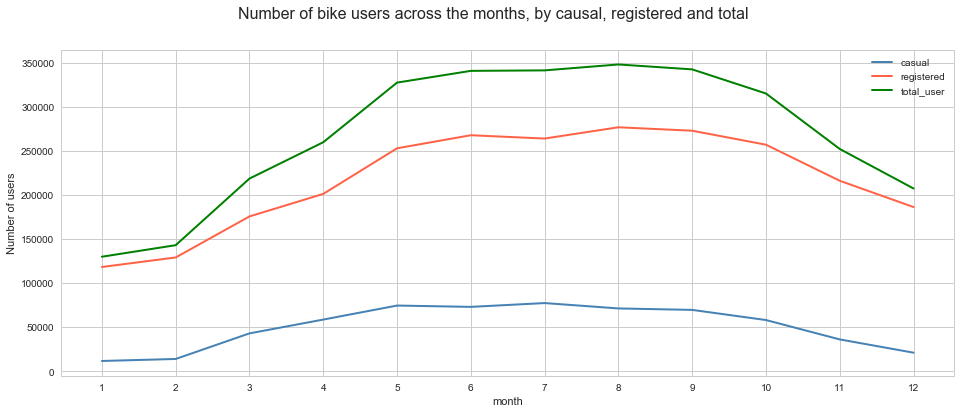

In [22]:
fig = plt.figure(figsize=DIMS)
ax = fig.add_subplot(111)

month_df_hours_agg.plot(kind='line', x='month', y='casual', marker='', color='steelblue', ax=ax, linewidth=2,label='casual')
month_df_hours_agg.plot(kind='line', x='month', y='registered', marker='', color='tomato', ax=ax, linewidth=2,label='registered')
month_df_hours_agg.plot(kind='line', x='month', y='total_user', marker='', color='green', ax=ax, linewidth=2,label='total_user')
plt.xticks(np.arange(1,13,1))
plt.ylabel('Number of users')
plt.legend
fig.suptitle('Number of bike users across the months, by causal, registered and total', fontsize=16)
plt.show()


While the general trend of casual and registered users are similar across the months, there are significantly more registered than casual users. This suggests registered users contributed more to the total pool of bike users. 

In [23]:
season_df_hours = clean_df_hours.copy()
season_df_hours = season_df_hours[['total_user', 'casual', 'registered','season']]
season_df_hours_agg = season_df_hours.groupby('season').sum()
season_df_hours_agg

,total_user,casual,registered
season,,,
1,447805,57722,390083
2,899436,199638,699798
3,1051198,223909,827289
4,831762,127636,704126


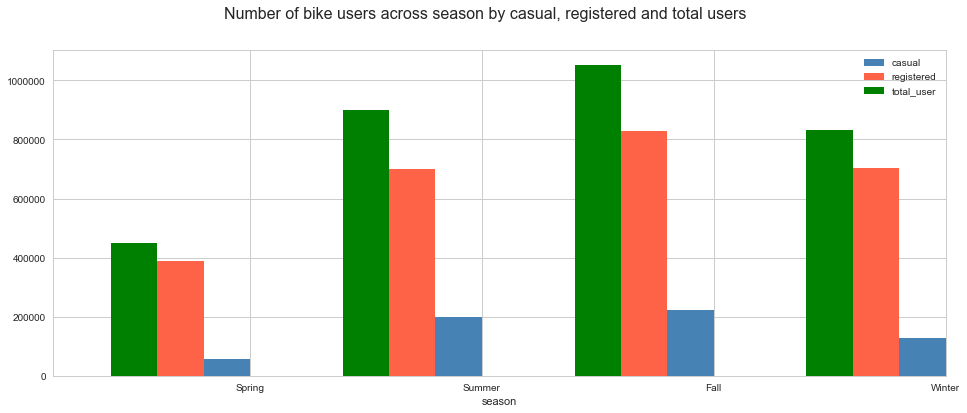

In [24]:
width=0.20
fig = plt.figure(figsize=DIMS)
ax = fig.add_subplot(111)

season_df_hours_agg.plot(kind='bar',  y='casual', ax=ax, position=1, width=width, color='steelblue',rot = 0)
season_df_hours_agg.plot(kind='bar',  y='registered', ax=ax, position=2, width=width, color='tomato',rot = 0)
season_df_hours_agg.plot(kind='bar',  y='total_user', ax=ax, position=3, width=width, color='green',rot = 0)

fig.suptitle("Number of bike users across season by casual, registered and total users", fontsize=16)

ax.set_xticklabels(('Spring', 'Summer', 'Fall', 'Winter')) 
plt.show()

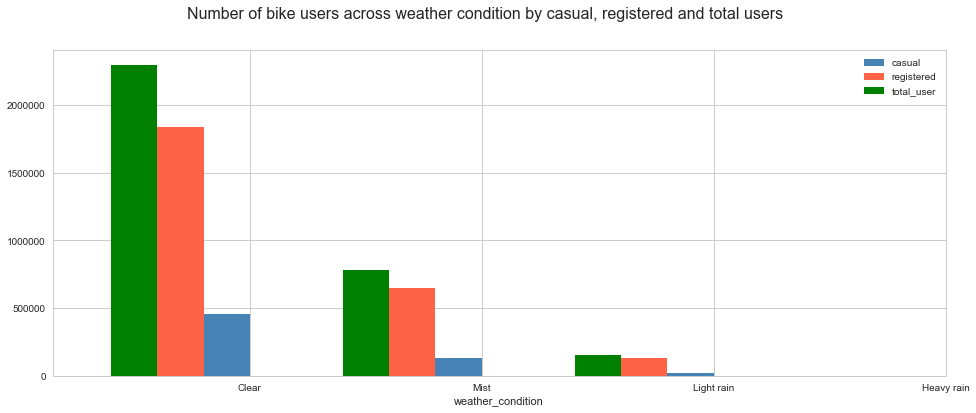

In [25]:
weather_df_hours = clean_df_hours.copy()
weather_df_hours = weather_df_hours[['total_user', 'casual', 'registered','weather_condition']]
weather_df_hours_agg = weather_df_hours.groupby('weather_condition').sum()

width=0.20
fig = plt.figure(figsize=DIMS)
ax = fig.add_subplot(111)

weather_df_hours_agg.plot(kind='bar',  y='casual', ax=ax, position=1, width=width, color='steelblue',rot = 0)
weather_df_hours_agg.plot(kind='bar',  y='registered', ax=ax, position=2, width=width, color='tomato',rot = 0)
weather_df_hours_agg.plot(kind='bar',  y='total_user', ax=ax, position=3, width=width, color='green',rot = 0)

fig.suptitle("Number of bike users across weather condition by casual, registered and total users", fontsize=16)

ax.set_xticklabels(('Clear', 'Mist', 'Light rain', 'Heavy rain')) 
plt.show()

In [26]:
df_matrix = df_hours.copy()
df_matrix = df_matrix.iloc[:, 2:17]
corr = df_matrix.corr()
corr

,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_user
season,1.00,-0.01,0.83,-0.01,-0.01,-0.00,0.01,-0.01,0.31,0.32,0.15,-0.15,0.12,0.17,0.18
year,-0.01,1.00,-0.01,-0.00,0.01,-0.00,-0.00,-0.02,0.04,0.04,-0.08,-0.01,0.14,0.25,0.25
month,0.83,-0.01,1.00,-0.01,0.02,0.01,-0.00,0.01,0.20,0.21,0.16,-0.14,0.07,0.12,0.12
hour,-0.01,-0.00,-0.01,1.00,0.00,-0.00,0.00,-0.02,0.14,0.13,-0.28,0.14,0.30,0.37,0.39
is_holiday,-0.01,0.01,0.02,0.00,1.00,-0.10,-0.25,-0.02,-0.03,-0.03,-0.01,0.00,0.03,-0.05,-0.03
weekday,-0.00,-0.00,0.01,-0.00,-0.10,1.00,0.04,0.00,-0.00,-0.01,-0.04,0.01,0.03,0.02,0.03
is_workingday,0.01,-0.00,-0.00,0.00,-0.25,0.04,1.00,0.04,0.06,0.05,0.02,-0.01,-0.30,0.13,0.03
weather_condition,-0.01,-0.02,0.01,-0.02,-0.02,0.00,0.04,1.00,-0.10,-0.11,0.42,0.03,-0.15,-0.12,-0.14
actual_temp,0.31,0.04,0.20,0.14,-0.03,-0.00,0.06,-0.10,1.00,0.99,-0.07,-0.02,0.46,0.34,0.40
feeling_temp,0.32,0.04,0.21,0.13,-0.03,-0.01,0.05,-0.11,0.99,1.00,-0.05,-0.06,0.45,0.33,0.40


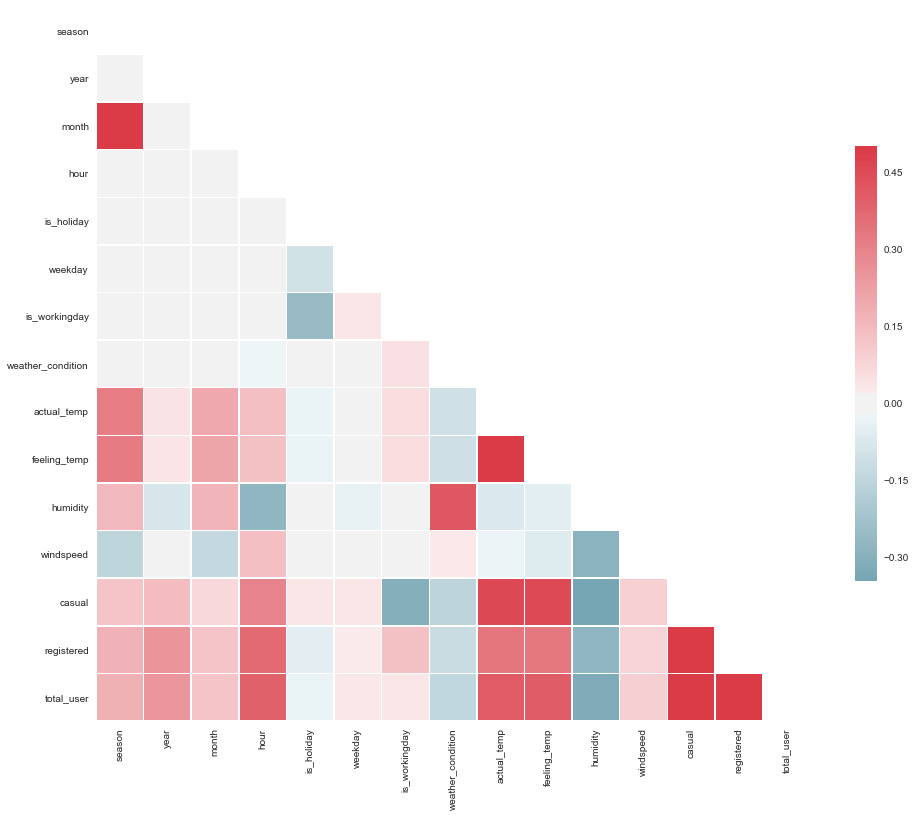

In [27]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 16))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the heatmap, we can see that:
- `Hour` is moderately correlated to the demand of registered and casual users, though a stronger correlation is observed for demand of registered. This reiterates the conclusion from boxplot distribution that registered users tend to comprise of working adults who cycle as (one of) their means of transport to work.
- `Feeling_temp` shares a stronger correlation with `casual` user than that of `registered` user. This shows that casual users perceive feeling_temp to be a more important factor in deciding whether to cycle compared to registered user. This reinforced the earlier hypothses that casual users cycle for leisure and consider environment factors in their decision making, while registered users are mainly working adults who cycle to work do not have the luxury to decide based on environment factors. This postulation that registered users are working adults is further supported by the finding that `is_working day` is positively correlated with `registered` users.
- Similar observation can be made for `humidity`, just that it is negatively correlated with demand of `casual` and `registered`.

From the earlier exploratory analysis, we see that there is a different distribution for casual and registered users. Thus, we will analyse these 2 groups separately
- To find out if linear regression is possible, I use a scatterplot to explore if there is a linear relationship between some of the attributes and casual and registered users

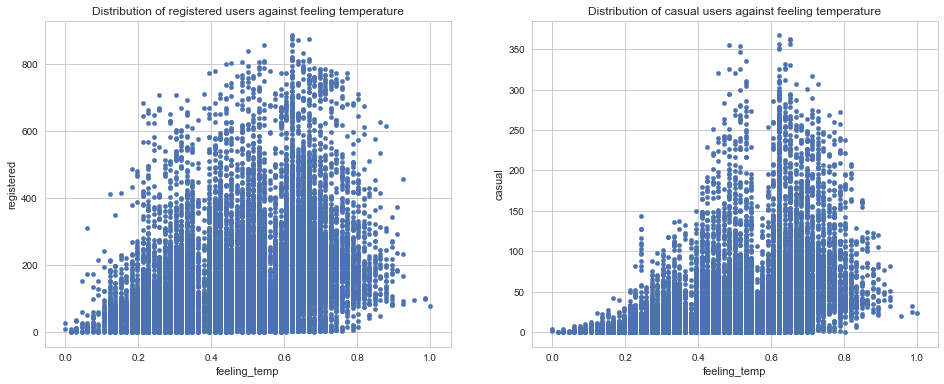

In [28]:
fig = plt.figure(figsize=DIMS)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Distribution of registered users against feeling temperature')
ax2.set_title('Distribution of casual users against feeling temperature')

df_matrix.plot(kind='scatter', y='registered', x='feeling_temp', ax=ax1)
df_matrix.plot(kind='scatter', y='casual', x='feeling_temp', ax=ax2)

plt.show()

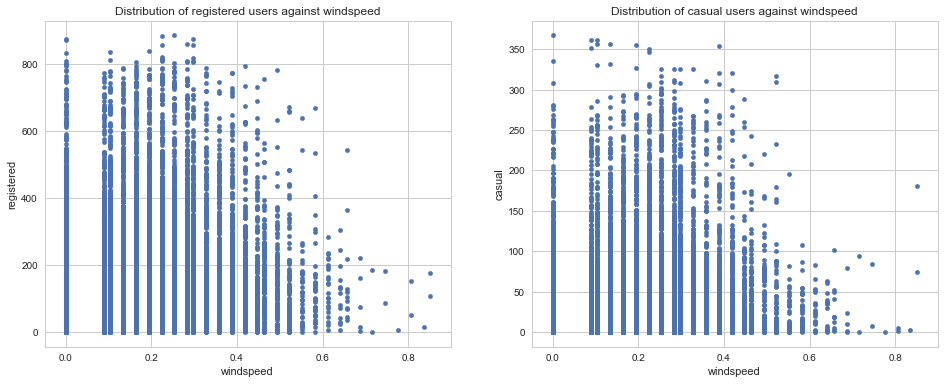

In [29]:
fig = plt.figure(figsize=DIMS)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Distribution of registered users against windspeed')
ax2.set_title('Distribution of casual users against windspeed')

df_matrix.plot(kind='scatter', y='registered', x='windspeed', ax=ax1)
df_matrix.plot(kind='scatter', y='casual', x='windspeed', ax=ax2)
plt.show()

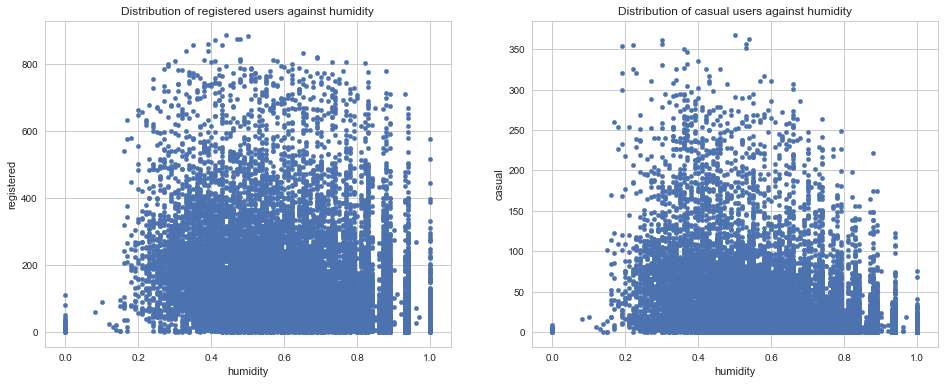

In [30]:
fig = plt.figure(figsize=DIMS)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Distribution of registered users against humidity')
ax2.set_title('Distribution of casual users against humidity')

df_matrix.plot(kind='scatter', y='registered', x='humidity', ax=ax1)
df_matrix.plot(kind='scatter', y='casual', x='humidity', ax=ax2)

plt.show()

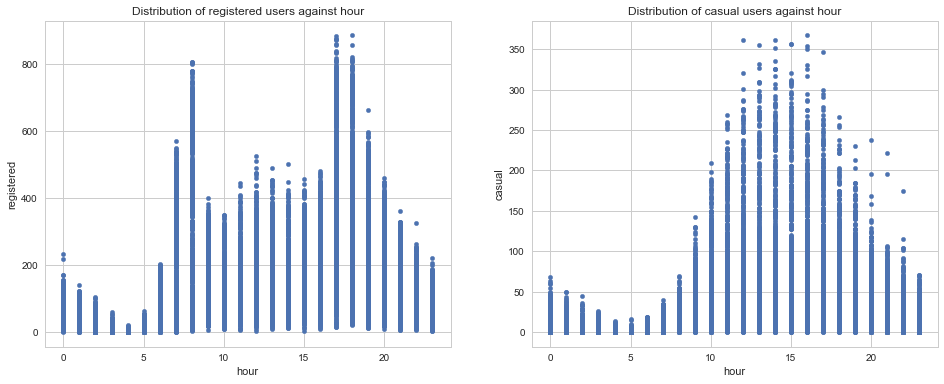

In [31]:
fig = plt.figure(figsize=DIMS)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Distribution of registered users against hour')
ax2.set_title('Distribution of casual users against hour')

df_matrix.plot(kind='scatter', y='registered', x='hour', ax=ax1)
df_matrix.plot(kind='scatter', y='casual', x='hour', ax=ax2)

plt.show()

Since there is no clear structure to the data, we will use models like decision tree and random forest to try and make sense of patterns in the data

### Predictive modelling

Since decision trees are robust to outliers, and there is a sizeable dataset of 17000 records, I'll use the raw dataset instead of clean set that removed outliers

### Decision Tree Model 
#### predict demand of **casual** bike users (baseline model - includes all attributes)

In [32]:
df_array = df_hours.values
X = df_array[:, 2:14]
y = df_array[:, [15]]

#### Model 1: No pruning

####  Using 10 fold cross validation

In [33]:

kf = KFold(n_splits=10) 
kf.get_n_splits(X) 
print(kf) 

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


KFold(n_splits=10, random_state=None, shuffle=False)


In [34]:

#Train
regr_1_nopruning = DecisionTreeRegressor(random_state=0)
dt = regr_1_nopruning.fit(X_train, y_train)   

#Test
y_pred= regr_1_nopruning.predict(X_test)


In [35]:
#Evaluate
msle = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", msle)

rmsle = sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE: ", rmsle)

r2 = r2_score(y_test, y_pred)
print('R squared: ', r2)

MSLE:  0.40315346799322194
RMSLE:  0.6349436730870085
R squared:  0.6107621999958546


RMSLE is suitable for our problem because RMSLE penalises an underprediction more than an over prediction. The bike sharing company would lose revenue if the number of bikes will be less than the demand for the bikes.

Determine Feature Importance

In [36]:
print("Feature importances:\n{}".format(regr_1_nopruning.feature_importances_))

Feature importances:
[0.0067137  0.09579712 0.05198908 0.56345204 0.00201434 0.01247988
 0.15222144 0.01701428 0.04843805 0.01743363 0.02322877 0.00921767]


In [37]:
df_hours.head()
X = df_hours.iloc[:, 2:14]
bike_demand_features = X.columns
bike_demand_features

feature_importances = pd.DataFrame(regr_1_nopruning.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', 
                                                                        ascending=False)
feature_importances

,importance
hour,0.56
is_workingday,0.15
year,0.10
month,0.05
actual_temp,0.05
humidity,0.02
feeling_temp,0.02
weather_condition,0.02
weekday,0.01
windspeed,0.01


Re-run model, starting with all features and ending with a subset with the most important feature

In [38]:

thresholds = sort(regr_1_nopruning.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(regr_1_nopruning, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model1 = DecisionTreeRegressor(random_state=0)
    selection_model1.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model1.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    rmsle = sqrt(mean_squared_log_error(y_test, predictions))
    print("Thresh=%.3f, n=%d, RMSLE: %.2f" % (thresh, select_X_train.shape[1], rmsle))

Thresh=0.002, n=12, RMSLE: 0.63
Thresh=0.007, n=11, RMSLE: 0.61
Thresh=0.009, n=10, RMSLE: 0.66
Thresh=0.012, n=9, RMSLE: 0.66
Thresh=0.017, n=8, RMSLE: 0.68
Thresh=0.017, n=7, RMSLE: 0.73
Thresh=0.023, n=6, RMSLE: 0.73
Thresh=0.048, n=5, RMSLE: 0.72
Thresh=0.052, n=4, RMSLE: 0.73
Thresh=0.096, n=3, RMSLE: 0.66
Thresh=0.152, n=2, RMSLE: 0.62
Thresh=0.563, n=1, RMSLE: 0.79


Conclusion: The factors that most accurately predict demand for casual users are all the attributes, except for `whether it is a holiday`, as this model gives the lowest RMSLE on the test data of 0.71.

#### Model 2: Pruning
#### Train

In [39]:
regr_depth5 = DecisionTreeRegressor(random_state=0, max_depth=5)
regr_depth10 = DecisionTreeRegressor(random_state=0, max_depth=10)
regr_depth15 = DecisionTreeRegressor(random_state=0, max_depth=15)
regr_depth12 = DecisionTreeRegressor(random_state=0, max_depth=12)
regr_depth11 = DecisionTreeRegressor(random_state=0, max_depth=11)

regr_depth5.fit(X_train, y_train)
regr_depth10.fit(X_train, y_train)
regr_depth15.fit(X_train, y_train)
regr_depth12.fit(X_train, y_train)
regr_depth11.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

#### Test

In [40]:
y_pred2 = regr_depth5.predict(X_test)
y_pred3 = regr_depth10.predict(X_test)
y_pred4 = regr_depth15.predict(X_test)
y_pred5 = regr_depth12.predict(X_test)
y_pred6 = regr_depth11.predict(X_test)


#### Evaluate

In [41]:
rmsle2 = sqrt(mean_squared_log_error(y_test, y_pred2))
print("RMSLE_max_depth_5: ", rmsle2)

rmsle3 = sqrt(mean_squared_log_error(y_test, y_pred3))
print("RMSLE_max_depth_10: ", rmsle3)

rmsle4 = sqrt(mean_squared_log_error(y_test, y_pred4))
print("RMSLE_max_depth_15: ", rmsle4)

rmsle5 = sqrt(mean_squared_log_error(y_test, y_pred5))
print("RMSLE_max_depth_12: ", rmsle5)

rmsle6 = sqrt(mean_squared_log_error(y_test, y_pred6))
print("RMSLE_max_depth_11: ", rmsle6)

RMSLE_max_depth_5:  0.7481309920294086
RMSLE_max_depth_10:  0.603593583100588
RMSLE_max_depth_15:  0.6148804408604575
RMSLE_max_depth_12:  0.6099441334409753
RMSLE_max_depth_11:  0.5879768351693864


Conclusion: For a baseline model predicting demand for casual users, the lowest value for 10 fold cross validation RMSLE of 0.588 was found with  max_depth = 11.

Model 3: I'll explore if a model that includes all attributes except `whether it is a holiday` with a parameter of max_depth = 11 results in a higher accuracy, since the inlcusion of these attributes result in the lowest RMSLE.

In [42]:
df_array = df_hours.values
X = df_array[:, [2,3,4,5,7,8,9,10,11,12,13,14]]
y = df_array[:, 15]

kf = KFold(n_splits=10) 
kf.get_n_splits(X) 
print(kf) 

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

regr_depth11 = DecisionTreeRegressor(random_state=0, max_depth=11)
regr_depth11.fit(X_train, y_train)   
y_pred= regr_depth11.predict(X_test)
rmsle = sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE: ", rmsle)

KFold(n_splits=10, random_state=None, shuffle=False)
RMSLE:  0.5529356402070379


Model 3 gives the lowest RMSLE. A decision tree with a max depth of 11 is the golden spot that minimises the issue of overfitting and thus provides DC bike sharing company with  more flexibility in predictive forecasting. 

However, including multiple predicors in a model may lead to overfitting of the model and redundancy of predictors. The correlation heatmap shows multiple predictors show moderate correlation, thus it is likely they are redundant.

Model 4 will include `hour` and `whether it is a working day` since these 2 attributes result in the second lowest RMSLE, with a parameter of max depth 11

In [43]:
df_array = df_hours.values
X = df_array[:, [5,8]]
y = df_array[:, 15]

kf = KFold(n_splits=10) 
kf.get_n_splits(X) 
print(kf) 

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

regr_depth11 = DecisionTreeRegressor(random_state=0, max_depth=11)
regr_depth11.fit(X_train, y_train)   
y_pred= regr_depth11.predict(X_test)
rmsle = sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE: ", rmsle)

KFold(n_splits=10, random_state=None, shuffle=False)
RMSLE:  0.6149612834215166


While model 4 results in a higher error than model 3, the cost of overfitting is greater than having model 3 that more accurately predicts future demand. This is because overfitting entails the bike sharing company may be unable to account for unexpected data points that it may wish to predict

Given the results from model 4, DC Bike sharing company can consider implementing price surge during peak hours on non-working days (since there are more casual users when it is not a working day, as shown by moderate negative correlation [-0.3] between these 2 factors), ie 10:00 to 17:00 on non-working days, to increase their revenue. 

### Decision Tree Model 
#### predict demand of **registered** bike users (baseline model - includes all attributes)

In [44]:
df_array = df_hours.values
X = df_array[:, 2:14]
y = df_array[:, [16]]

#### Model 5: No pruning

#### Train

In [45]:
kf = KFold(n_splits=10) 
kf.get_n_splits(X) 
print(kf) 

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

regr_5_nopruning = DecisionTreeRegressor(random_state=0)
regr_5_nopruning.fit(X_train, y_train)   

KFold(n_splits=10, random_state=None, shuffle=False)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

#### Test

In [46]:
y_pred= regr_5_nopruning.predict(X_test)

#### Evaluate

In [47]:
rmsle = sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE: ", rmsle)

RMSLE:  0.6453299850598004


Conclusion: A baseline model that includes all attributes can predict demand of registered users of comparable accuracy as that of casual users, as RMSLE on the test data for registered users (0.64) is similar to casual users (0.63)

Determine Feature Importance

In [48]:
print("Feature importances:\n{}".format(regr_5_nopruning.feature_importances_))

Feature importances:
[0.01238993 0.07460618 0.01497725 0.60935905 0.00187942 0.0135334
 0.0581249  0.0170873  0.13730375 0.02390517 0.02686631 0.00996735]


In [49]:
df_hours.head()
X = df_hours.iloc[:, 2:14]
bike_demand_features = X.columns
bike_demand_features

feature_importances = pd.DataFrame(regr_5_nopruning.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', 
                                                                        ascending=False)
feature_importances

,importance
hour,0.61
actual_temp,0.14
year,0.07
is_workingday,0.06
humidity,0.03
feeling_temp,0.02
weather_condition,0.02
month,0.01
weekday,0.01
season,0.01


In [50]:
thresholds = sort(regr_5_nopruning.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(regr_5_nopruning, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model2 = DecisionTreeRegressor(random_state=0)
    selection_model2.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model2.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    rmsle = sqrt(mean_squared_log_error(y_test, predictions))
    print("Thresh=%.3f, n=%d, RMSLE: %.2f" % (thresh, select_X_train.shape[1], rmsle))

Thresh=0.002, n=12, RMSLE: 0.65
Thresh=0.010, n=11, RMSLE: 0.65
Thresh=0.012, n=10, RMSLE: 0.63
Thresh=0.014, n=9, RMSLE: 0.66
Thresh=0.015, n=8, RMSLE: 0.66
Thresh=0.017, n=7, RMSLE: 0.66
Thresh=0.024, n=6, RMSLE: 0.69
Thresh=0.027, n=5, RMSLE: 0.69
Thresh=0.058, n=4, RMSLE: 0.61
Thresh=0.075, n=3, RMSLE: 0.77
Thresh=0.137, n=2, RMSLE: 0.75
Thresh=0.609, n=1, RMSLE: 0.80


Conclusion: The factors that most accurately predict demand for registered users are `hour`, `actual temp`, `year` and `whether it is a working day` , as this model gives the lowest RMSLE on the test data of 0.61. This result reinforces the previous finding that most registered users are working adults who cycle as (part of) their means of transport to work. It is interesting that `actual temp` is a predictive attribute. This suggests that the bike sharing company can consider incorporating information on temperature into their forecasting. The finding that `year` is a predictive attribute shows that Capital BikeShare was successful and committed in its planning, implementation and expansion since its launch in late 2010, as opposed to its predecessor, SmartBike DC.

#### Model 6: Pruning

#### Train

In [51]:
regr_depth5 = DecisionTreeRegressor(random_state=0, max_depth=5)
regr_depth10 = DecisionTreeRegressor(random_state=0, max_depth=10)
regr_depth15 = DecisionTreeRegressor(random_state=0, max_depth=15)
regr_depth9 = DecisionTreeRegressor(random_state=0, max_depth=9)
regr_depth8 = DecisionTreeRegressor(random_state=0, max_depth=8)


regr_depth5.fit(X_train, y_train)
regr_depth10.fit(X_train, y_train)
regr_depth15.fit(X_train, y_train)
regr_depth9.fit(X_train, y_train)
regr_depth8.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

#### Test

In [52]:
y_pred2 = regr_depth5.predict(X_test)
y_pred3 = regr_depth10.predict(X_test)
y_pred4 = regr_depth15.predict(X_test)
y_pred5 = regr_depth9.predict(X_test)
y_pred6 = regr_depth8.predict(X_test)

#### Evaluate

In [53]:
rmsle2 = sqrt(mean_squared_log_error(y_test, y_pred2))
print("RMSLE_max_depth_5: ", rmsle2)

rmsle3 = sqrt(mean_squared_log_error(y_test, y_pred3))
print("RMSLE_max_depth_10: ", rmsle3)

rmsle4 = sqrt(mean_squared_log_error(y_test, y_pred4))
print("RMSLE_max_depth_15: ", rmsle4)

rmsle5 = sqrt(mean_squared_log_error(y_test, y_pred5))
print("RMSLE_max_depth_9: ", rmsle5)

rmsle6 = sqrt(mean_squared_log_error(y_test, y_pred6))
print("RMSLE_max_depth_8: ", rmsle6)

RMSLE_max_depth_5:  0.6778691957376766
RMSLE_max_depth_10:  0.6011996798883033
RMSLE_max_depth_15:  0.6349944428986267
RMSLE_max_depth_9:  0.5863462145584708
RMSLE_max_depth_8:  0.6069211430272332


Conclusion: For a baseline model predicting demand for registered users, the lowest value for 10 fold cross validation RMSLE of 0.586 was found with  max_depth = 9. This value is lower than the previous model without pruning

Model 7: I'll explore a model with a parameter of max depth 9 that includes `hour`, `actual temp`, `year` and `whether it is a working day` 

In [54]:
df_array = df_hours.values
X = df_array[:, [3,5,8,10]]
y = df_array[:, [15]]


#### Train

In [55]:
kf = KFold(n_splits=10) 
kf.get_n_splits(X) 
print(kf) 

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

regr_7_max_depth_9 = DecisionTreeRegressor(random_state=0, max_depth= 8)
regr_7_max_depth_9.fit(X_train, y_train)   

KFold(n_splits=10, random_state=None, shuffle=False)


DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

#### Test

In [56]:
y_pred = regr_7_max_depth_9.predict(X_test)

#### Evaluate

In [57]:
rmsle = sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE: ", rmsle)

RMSLE:  0.5888205443383144


Conclusion: Model 7 gives the lowest error. In addition to the previous recommendation to consider temperature information, given that `hour` and `whether it is a working day` are also predictive attributes to forecast demand of registered users, DC Bike sharing company can consider implementing  price surge during peak hours on working days (6:00-9:00 and 17:00-20:00) to increase their revenue. 

The impetus for the above strategy is further supported by earlier exploratory analysis showing that registered users contributed more to the total pool of bike users. Thus, DC Biks sharing company has the potential to boost its revenue by adjusting its pricing model to target this group of user.

#### Future work

With today’s technologies such as mobile devices, a bike sharing system is able to provide information on the departure and arrival locations of the bikes. Location is an informative dimension, which has the potential to provide richer and deeper analysis. With information of geo-referenced data, DC bike sharing company is able to to predict the relative demand at various locations, and tweak the current system to maintain sufficient number of bikes at each location if the problem of rebalancing arises. This allows for more targeted allocation of bikes, and circumvent the issue of rebalancing.

Furthermore, geospatial analysis can help the company to anticipate and prepare for possible changes due to changing spatial conditions or location-based events. With the benefit of foresight, the company has more time to respond to such changes, and adjust their pricing model or bike allocation to cater to their service users more effectively.